# Ontake dv/v - Rain&Snow Correction Cookbook


In [236]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 
import datetime
import matplotlib
# matplotlib.use('nbagg')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6) 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy.special import erf, erfc
# import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
# sns.set_style("whitegrid")
# sns.set_palette("bright")

In [237]:
pluvio = pd.read_csv(
    "../climate data/larger_area/climate_MSH.csv", index_col=0, parse_dates=True)


freq = 1.0  # frequency of the CC to use
vel = 2  # apparent surface wave velocity for depth sensitivity


# For testing purposes filter for only one coord
pluvio = pluvio[pluvio['latitude'] == 46.2]
pluvio = pluvio[np.isclose(pluvio['longitude'], -122.2)]
# assign new index
pluvio.index = np.arange(len(pluvio), dtype=int)


# #### changes by Peter ####
# create water influx as difference of melt and remaining snow
# note that snow has to be given in m water equivalent in precipitation in m
# meltwater[meltwater < 0] = 0
pluvio['water_influx'] = pluvio['total precipitation'] + pluvio['snowmelt'] - pluvio['snowfall']
# set to mm
pluvio["water_influx"] *= 1000

# ## original
# pluvio["water_influx"] = pluvio['total_precipitation']*1000

pluvio["rate"] = pluvio["water_influx"].ffill()

pluvio["load"] = 0.0
pluvio.loc[1:,"load"] = np.diff(pluvio["rate"]) * 9.81 * 1.0
pluvio['date'] = [datetime.datetime.strptime(dt, '%Y-%m-%d') for dt in pluvio['date']]
pluvio

,snow depth,total precipitation,snowmelt,snowfall,date,latitude,longitude,water_influx,rate,load
0,0.321027,0.002019,0.000000,0.001669,1993-01-01,46.2,-122.2,0.350318,0.350318,0.000000
1,0.321671,0.000187,0.000000,0.000124,1993-01-02,46.2,-122.2,0.062722,0.062722,-2.821318
2,0.322947,0.000962,0.000000,0.000201,1993-01-03,46.2,-122.2,0.761278,0.761278,6.852835
3,0.352102,0.015419,0.000000,0.010017,1993-01-04,46.2,-122.2,5.402854,5.402854,45.533863
4,0.356655,0.001759,0.000000,0.001400,1993-01-05,46.2,-122.2,0.359268,0.359268,-49.477579
...,...,...,...,...,...,...,...,...,...,...
10952,0.262859,0.027939,0.005412,0.000000,2022-12-27,46.2,-122.2,33.351128,33.351128,245.452454
10953,0.286556,0.015900,0.000296,0.014223,2022-12-28,46.2,-122.2,1.972261,1.972261,-307.826686
10954,0.291760,0.001439,0.000092,0.001059,2022-12-29,46.2,-122.2,0.472499,0.472499,-14.712664
10955,0.301303,0.012669,0.000674,0.003830,2022-12-30,46.2,-122.2,9.513777,9.513777,88.694934


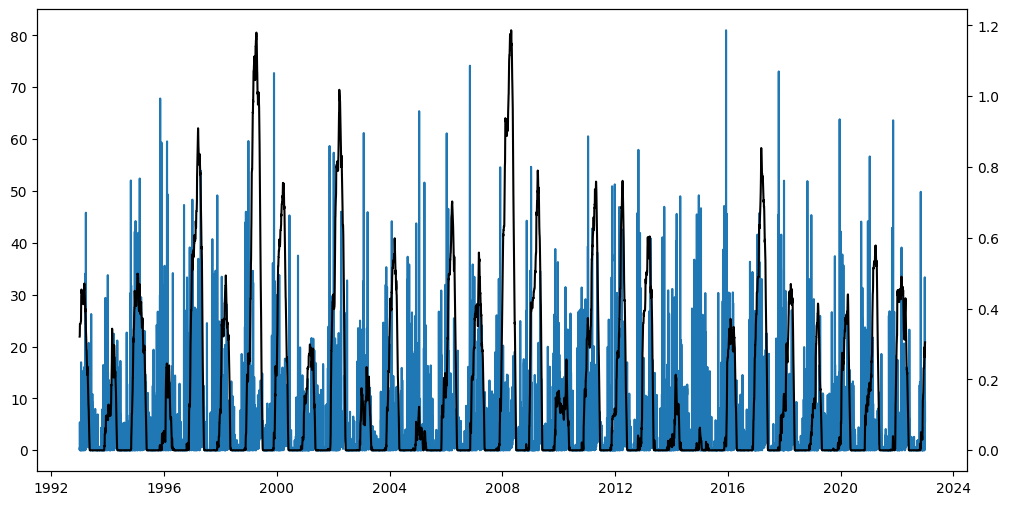

In [238]:
plt.plot(pluvio['date'], pluvio['water_influx'])
plt.twinx()
plt.plot(pluvio['date'], pluvio["snow depth"], 'k')
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())

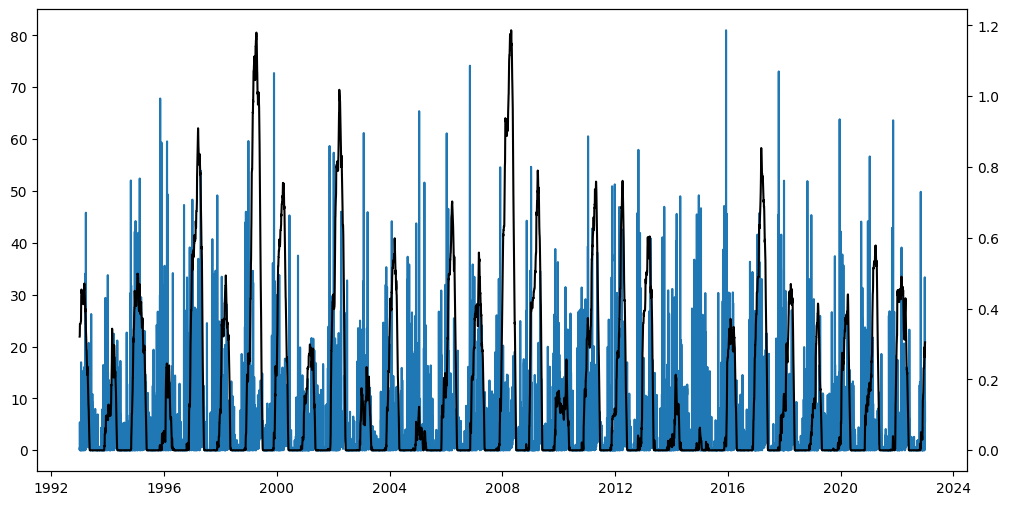

In [239]:
plt.plot(pluvio['date'], pluvio["rate"])
plt.twinx()
# pluvio["Snow depth (cm)"].plot(c='k')
plt.plot(pluvio['date'], pluvio["snow depth"], 'k')
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())

## Computing pore pressure change diffusion P(t,r)

The dmin parameter is defined as 1000 m manually, it is a subjective decision,
in the future it should probably be optimised automatically too.

The final P(t) is the linear average of P(t,r).

In [240]:

c = 0.6  # 1.0 # diffusivity
dt = 86400.0


dmin = 1000
dmax = 8000
dstep = 500

# change dmin dmax depending on frequency?
# for 1 Hz
# wavelen = vel/freq
# dmin = wavelen/20
# dmax = 2*wavelen/3
# dstep = (dmax-dmin)/10

depths = np.arange(dmin, dmax+dstep, dstep)
pluvio["P"] = 0.0
for r in depths:
    pluvio["P%i"%r] = 0.0

for t in range(len(pluvio)):
    X = np.arange(t)
    vals = pluvio.iloc[X]["load"].values
    for r in depths:
        n = t
        func = r/np.sqrt(4.0*c*(n-X)*dt)
        # first part of Eq in Rivet, not used by Wang
    #     a = np.sum(alpha * vals * erf(func))
        b = np.sum(vals * erfc(func))
        pluvio.loc[pluvio.index[t],"P"] += b
        pluvio.loc[pluvio.index[t],"P%i"%r] = b

pluvio["P"] /= len(depths)

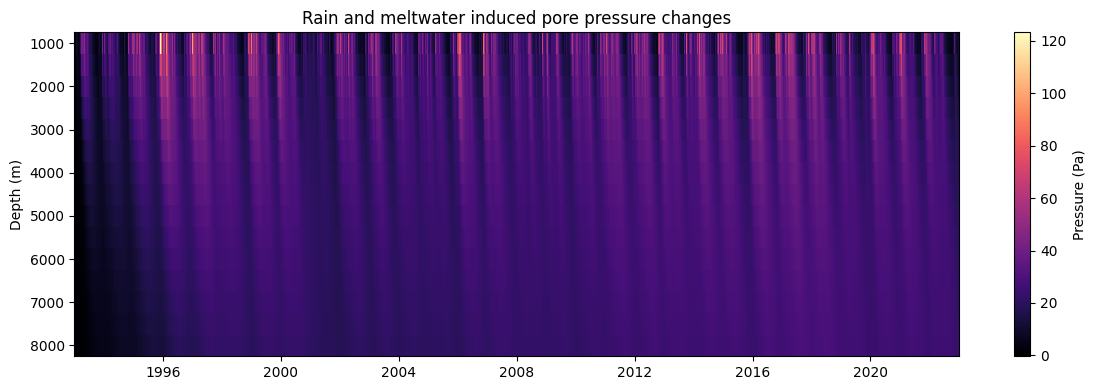

In [241]:
all = np.asarray([pluvio["P%i"%i] for i in depths])
plt.figure(figsize=(12,4))
plt.pcolormesh(pluvio["date"], depths, all, cmap="magma")
cb = plt.colorbar()
cb.set_label("Pressure (Pa)")
plt.gca().invert_yaxis()
plt.title("Rain and meltwater induced pore pressure changes")
plt.ylabel("Depth (m)")
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())
plt.tight_layout()
plt.show()

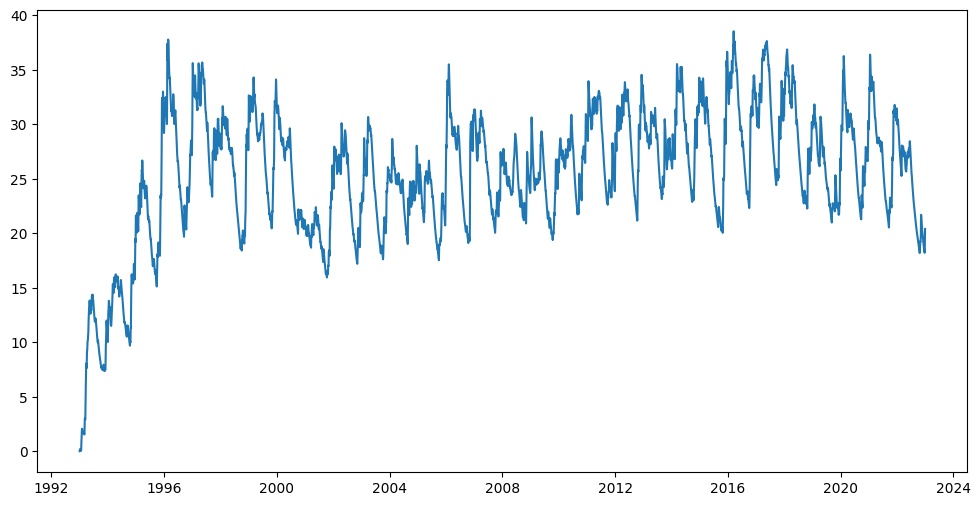

In [242]:
pluvio["P"] = all.mean(axis=0)
plt.plot(pluvio['date'], pluvio["P"].values)
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())


In [243]:
# read dv
from seismic.monitor.dv import read_dv
dv = read_dv(f'../dv/resp_removed_longtw_final_QCpass/xstations_{freq}-{freq*2}_wl864000_*_srw/average.npz')[0]

# let's filter a bit
mask = np.all([dv.avail, dv.corr>.25], axis=0)
corr_starts = np.array([tt.datetime for tt in dv.stats.corr_start])[mask]
# Let's do a linear detrend because the long term trend is probably not climate related
value = detrend(-1*dv.value[mask])

# df = pd.read_csv("results_2014_09_28/2019-inversion-ONTA_ONTA-100000.0.csv", index_col=0, parse_dates=True,names=["date", "M"])
# df = df.loc[pluvio.index[0]: pluvio.index[-1]].interpolate().ffill().bfill()
# df["M"] -= df["M"][0]
# df.tail()

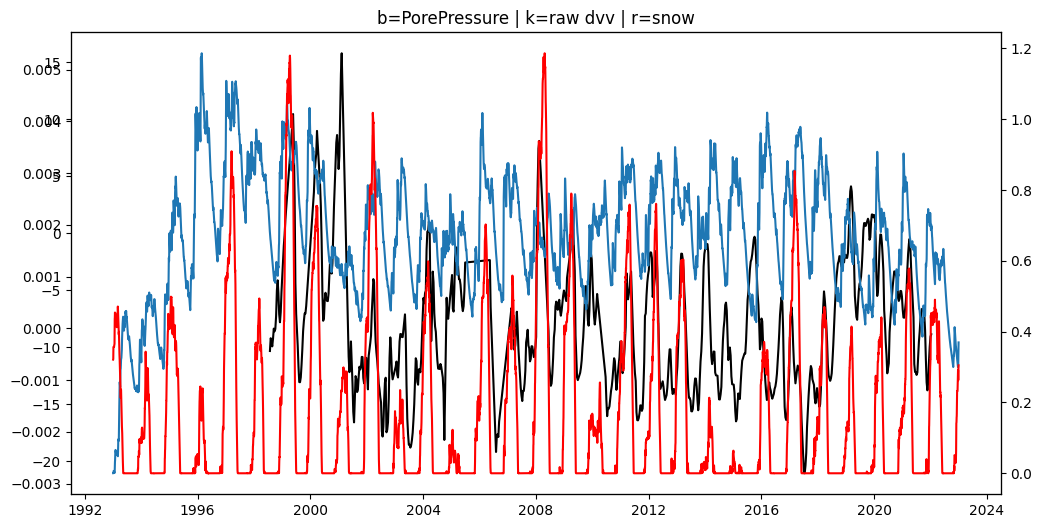

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [244]:
# pluvio = pluvio.loc["2013-01-01":]
pluvio["P"] = detrend(pluvio["P"])

plt.plot(corr_starts, value, c='k')
plt.twinx()
plt.plot(list(pluvio['date']), list(pluvio["P"]))
plt.twinx()
plt.plot(pluvio['date'], pluvio["snow depth"], c='r')
plt.title("b=PorePressure | k=raw dvv | r=snow")
plt.gca().xaxis.set_major_locator(mpl.dates.AutoDateLocator())
plt.show()
plt.savefig

In [245]:
from scipy.interpolate import interp1d
from obspy import UTCDateTime

x = [UTCDateTime(t).timestamp for t in corr_starts]
xq = [UTCDateTime(t).timestamp for t in pluvio['date']]
f = interp1d(x, value, bounds_error=False, fill_value=np.nan)
val_intp = f(xq)

pluvio["dtt"] = val_intp * -1.0
pluvio["dtt"] = pluvio['dtt'].ffill()

### Computing Wang's Eq(3) to obtain the P(t) vs dv/v_obs ratio

We do that on a visually well matching slice of the data (but including the long term seasonal bump)

In [246]:
pluvio = pluvio.dropna()
# modelled dv/v
ii = np.all(["2017-6-01">pluvio['date'], pluvio['date']>"2011-01-01"], axis=0)
sliced = pluvio[["P","dtt", 'snow depth']].loc[ii].copy()
#sliced = pluvio[["P","dtt"]].loc["2013-03-01":"2013-06-01"].copy()
sliced["P"] = detrend(sliced["P"])
sliced["dtt"] = detrend(sliced["dtt"])

ratio = np.cov(sliced["dtt"], sliced["P"])[1,0]/np.var(sliced["P"])
print(ratio)
predicted = sliced.dtt.mean() + ratio * (sliced["P"]-sliced["P"].mean())
print(1./ratio)

6.771232190081711e-05
14768.360793546095


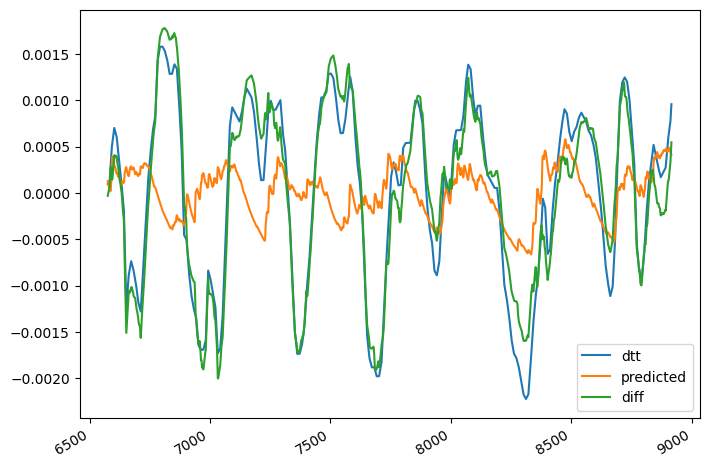

In [247]:
fig = plt.figure(figsize=(8,6))
plt.plot(sliced.index, sliced.dtt, label= 'dtt')
plt.plot(sliced.index, predicted, label ="predicted")
plt.plot(sliced.index, sliced.dtt - predicted, label='diff')
plt.legend()
fig.autofmt_xdate()
plt.show()

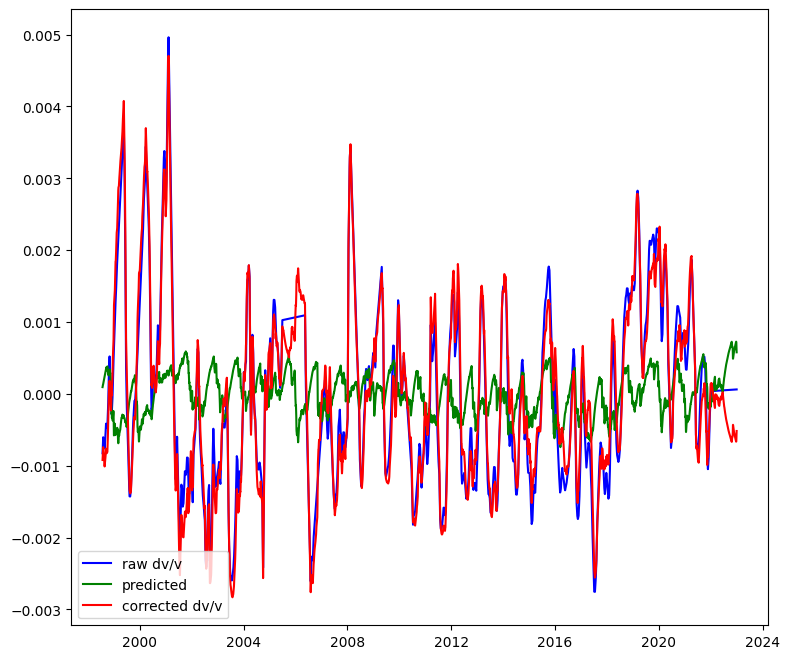

In [248]:
pluvio = pluvio.interpolate(method='ffill')
pluvio["P"] = detrend(pluvio["P"])
pluvio["dtt"] = detrend(pluvio["dtt"])
pluvio["predicted"] =  ratio * (pluvio["P"]-pluvio["P"].mean())

plt.figure(figsize=(9,8))
plt.plot(pluvio['date'], -1*pluvio["dtt"], c="b", label="raw dv/v")
plt.plot(pluvio['date'], -1*pluvio["predicted"], c="g", label="predicted")
plt.plot(pluvio['date'], -1*pluvio["dtt"] - (-1*pluvio["predicted"]), c="r", label="corrected dv/v")

# plt.plot(pluvio.index, -1*(pluvio["dtt (-dvv)"] - pluvio.P*factor*2),c="g", label="rain corrected dv/v")
plt.legend(loc=3, frameon=True)

#plt.xlim(datetime.datetime(2011,1,1),datetime.datetime(2018,1,1),)
plt.show()

## Define a,b mixing parameters manually

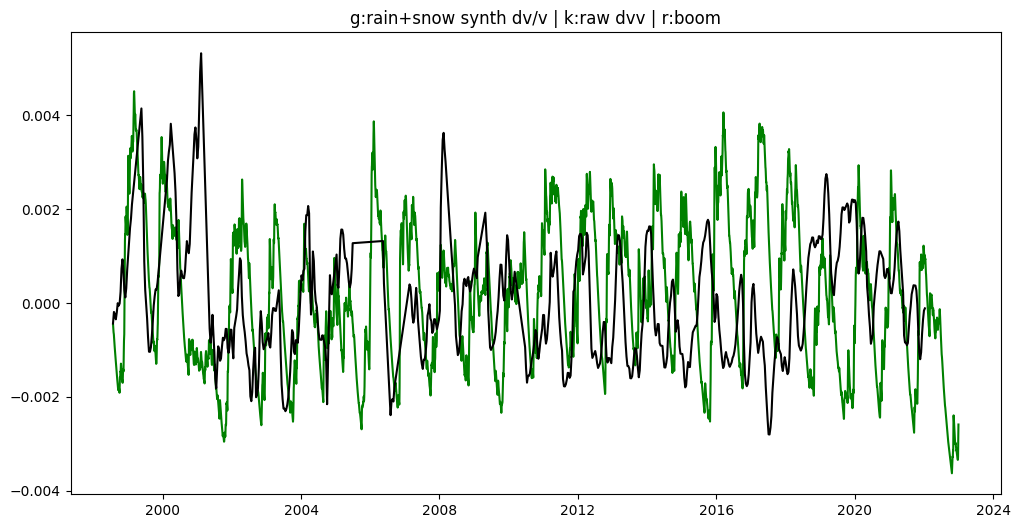

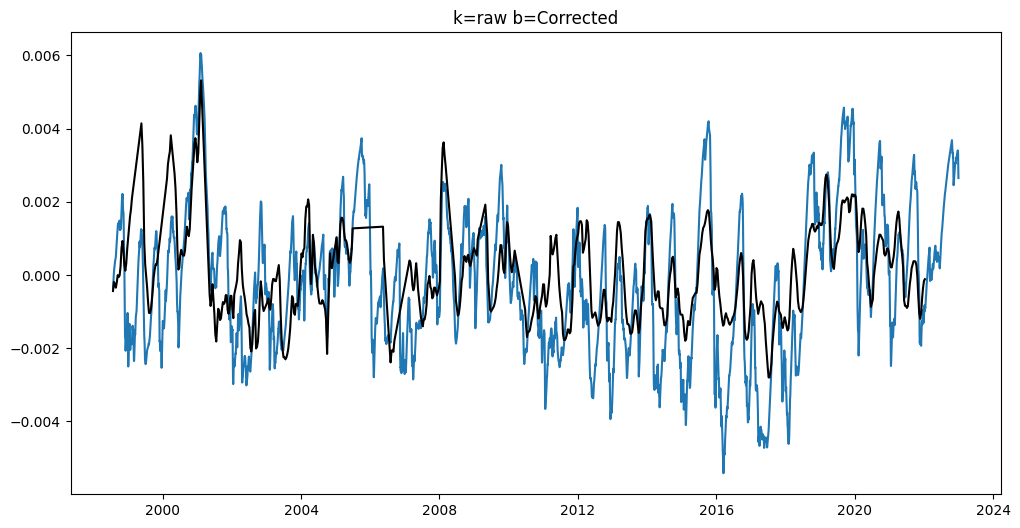

In [249]:
a = 5 #because we work with the "Predicted" dv/v, which includes the ratio computed above
b = 1e-3 #-5e-3


dvv = value
C = np.mean(dvv)

dvvsynth =  a * pluvio["predicted"] + b * pluvio["snow depth"] + C

plt.plot(pluvio['date'], dvvsynth , c="g", label="rain+snow synth dv/v")
# plt.twinx()
plt.plot(corr_starts, dvv , c="k", label="observed dv/v")
# plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.show()


plt.plot(pluvio['date'], -pluvio['dtt']-dvvsynth )






# plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(corr_starts, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=Corrected")
plt.show()


## Define a,b mixing parameters automatically by optimization

In this case, we don't have to define a "visually well matching time slice" of the data. All data are taken into account
in the optimization process.

In [250]:
from scipy.optimize import minimize

In [251]:
pluvio["P"] -= pluvio["P"].mean()
fun = lambda x: (((x[0] * pluvio["P"] + x[1] * pluvio["snow depth"]) - pluvio["dtt"])**2).sum()
res = minimize(fun, [0.0, 0.0])
print(res)
a, b = res.x
print(a, b)


# sliced["P"] -= sliced["P"].mean()

# fun = lambda x: (((x[0] * sliced["P"] + x[1] * sliced["snow_depth"]) - sliced["dtt"])**2).sum()
# res = minimize(fun, [0.0, 0.0])
# print(res)
# a, b = res.x

      fun: 0.011805240504504008
 hess_inv: array([[ 3.63084291e-06, -1.84712509e-05],
       [-1.84712509e-05,  7.38882661e-04]])
      jac: array([2.32830644e-10, 1.16415322e-10])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([ 6.05283826e-05, -1.88625761e-03])
6.0528382592780164e-05 -0.001886257613559652


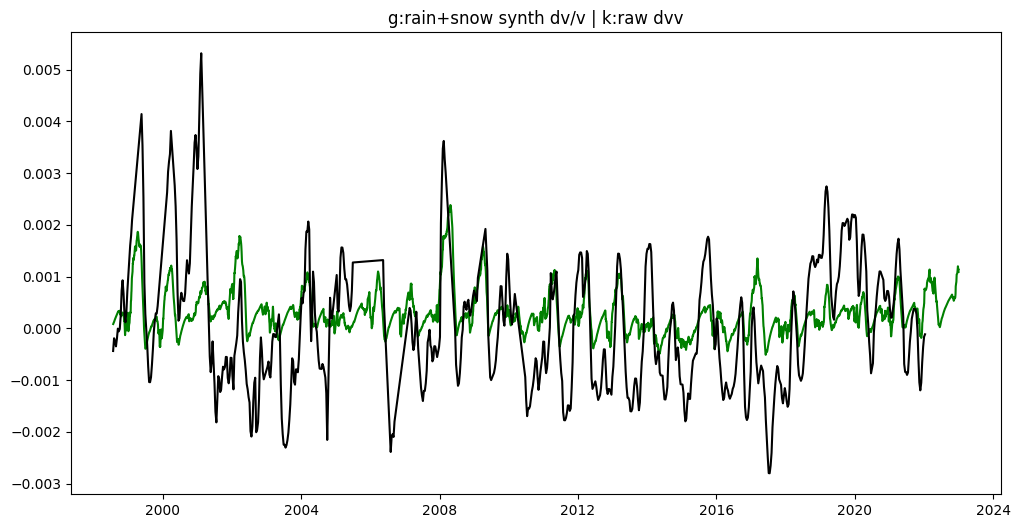

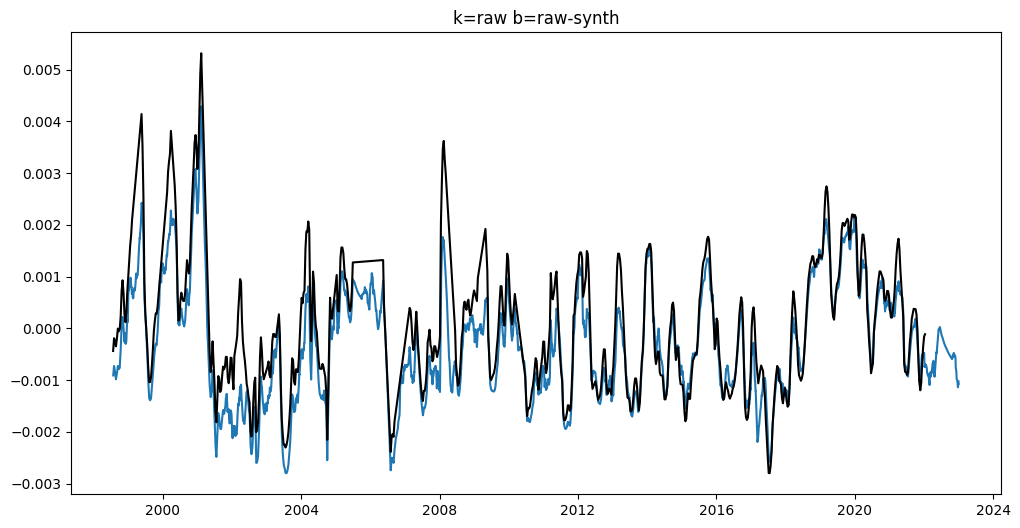

In [252]:
# dvv = df["M"]
dvvsynth =  -1*(a * pluvio["P"] + b * pluvio["snow depth"]) + C
# dvv.to_csv('dvv_data.csv')
plt.plot(pluvio['date'], dvvsynth , c="g", label="rain+snow synth dv/v")
# plt.twinx()
plt.plot(corr_starts, dvv , c="k", label="observed dv/v")
plt.title("g:rain+snow synth dv/v | k:raw dvv")
# plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

plt.plot(pluvio['date'], -pluvio['dtt']-dvvsynth )

plt.plot(corr_starts, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=raw-synth")
plt.show()


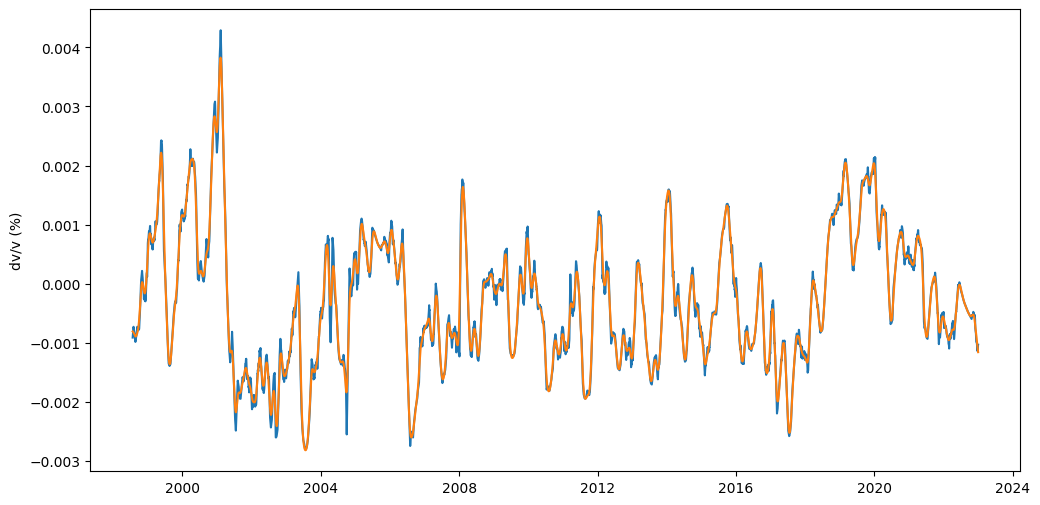

In [253]:
plt.plot(pluvio['date'], -pluvio['dtt']-dvvsynth )
c,t = hpfilter(-pluvio['dtt']-dvvsynth, 10000)
plt.plot(pluvio['date'], t)
plt.ylabel("dv/v (%)")
plt.show()

# read events

In [21]:
def read_event_catalog(file, tz=0):
    names = ["Year","Month","Day","Hour","Minute","Second","Latitude","Longitude","Depth","Magnitude"]
    events = pd.read_csv(file, header=None, names=names, delim_whitespace=True)
    dt = [datetime.datetime(2000+int(r["Year"]),int(r["Month"]),int(r["Day"]),int(r["Hour"]),int(r["Minute"]))+datetime.timedelta(r["Second"]) for id, r in events.iterrows()]
    if tz != 0:
        dt = [d-datetime.timedelta(hours=tz) for d in dt]
    events.index = pd.DatetimeIndex(dt)
    for _ in ["Year","Month","Day","Hour","Minute","Second"]:
        del events[_]
    events = events.sort_index()
    return events

In [22]:
VT = read_event_catalog("ontake_hypo.MAD100", tz=9)
LP = read_event_catalog("ontake_hypoLP.MAD130", tz=9)

<IPython.core.display.Javascript object>


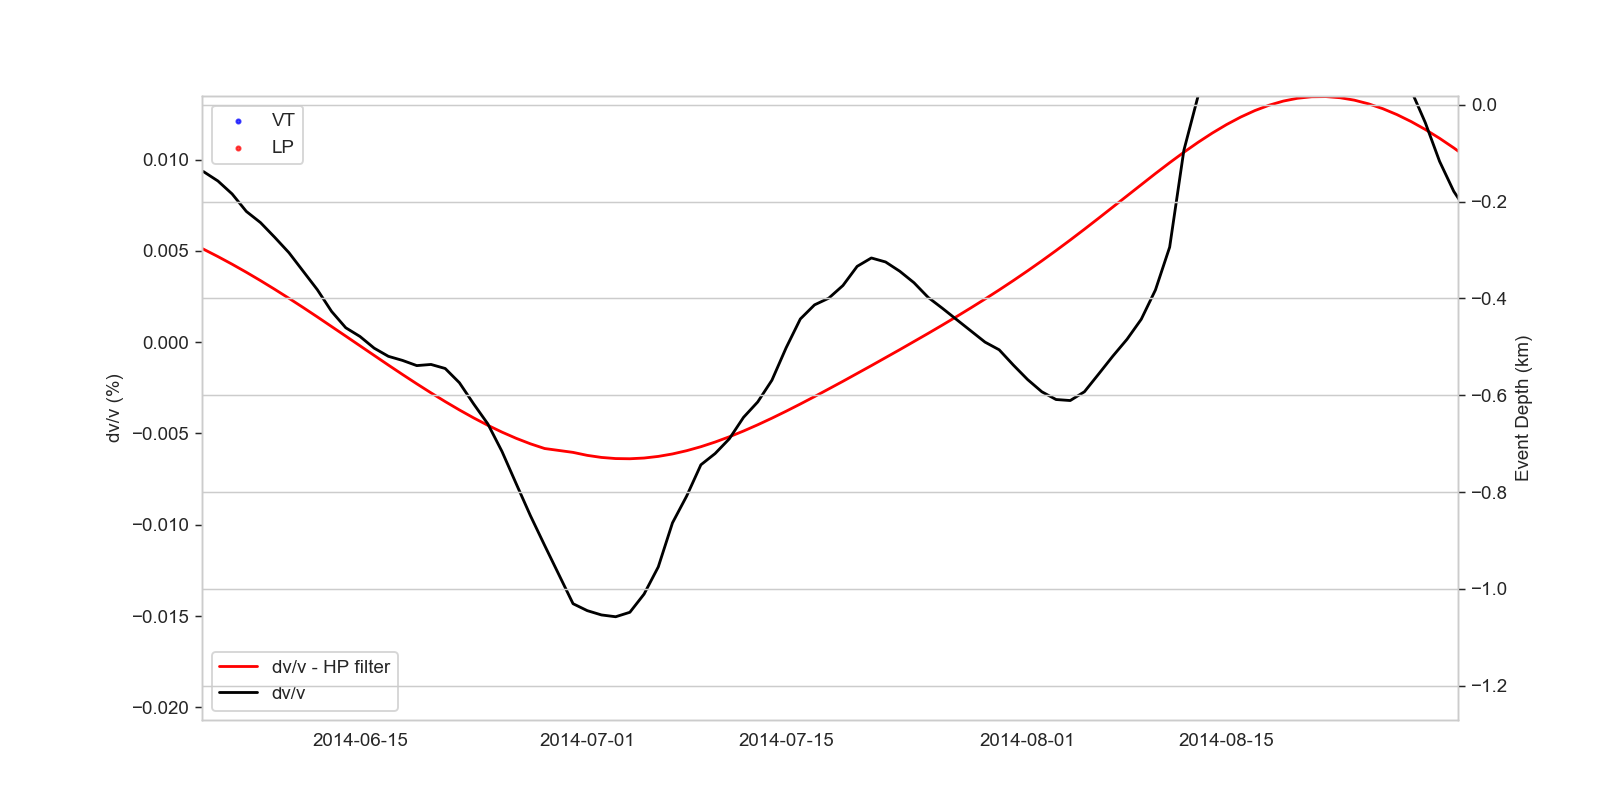

In [23]:
plt.plot(pluvio.index, t, label="dv/v - HP filter", c='r')
plt.plot(pluvio.index, dvv-dvvsynth, label="dv/v", c='k' )
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.grid(False)
plt.ylabel("dv/v (%)")
plt.legend(loc=3)
plt.twinx()
plt.scatter(VT.index, VT["Depth"], label="VT", s=5,alpha = 0.7,c='b')
plt.scatter(LP.index, LP["Depth"], c='r', label="LP",s=5,alpha = 0.7)
plt.legend(loc=3)
plt.ylabel("Event Depth (km)")


plt.legend(loc=2)
plt.savefig('Fig4.pdf',dpi=300)
plt.show()

In [ ]:
VT["type"] = "VT"
LP["type"] = "LP"
events= pd.concat((VT,LP))
print(events.head())

In [ ]:
events.to_csv("ListEvents_WithCat.csv")

In [ ]:
VT.index

In [ ]:
dvv = df["M"]
dvvsynth =  -1*(a * pluvio["P"] + b * pluvio["Snow depth (cm)"])


plt.plot(pluvio.index, dvvsynth , c="g", label="rain+snow synth dv/v")
plt.twinx()
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

plt.plot(pluvio.index, dvv-dvvsynth )

plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=raw-synth")


ax=plt.twinx()
detec = pd.read_csv(r'C:\Users\caudroco\Documents\Ontake\Nov_2019\template_matching\detections_per_12h.csv',index_col=0, header=0, parse_dates=True)
ax.plot(detec.index,detec.detect_val,c='k')


plt.show()





In [23]:
### stress transfer

# m/s
vel = 10e-3
# 36 km between 
distance = 36000

time = (distance/vel)/(3600*24)
print(time)

41.666666666666664


In [25]:
# m/s
time = (3600*24*30)
# 36 km between 
distance = 36000

vel = (distance/time)
print(vel)

0.013888888888888888
